# 2D plotting of LES output
* The below notebook compares selected simulations against observational targets that were collected from satellite and ground-based retrievals.
* In case of questions or concerns, please notify Ann Fridlind (ann.fridlind@nasa.gov), Timothy Juliano (tjuliano@ucar.edu), and Florian Tornow (ft2544@columbia.edu).

In [1]:

import glob, os
import geopy
import geopy.distance

os.getcwd()


'/user-data-home/comble-mip/notebooks/plotting'

In [126]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")

%run functions_plotting.py 

## read trajectory
ds = nc.Dataset('../../data_files/theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18.nc')
les_time = 18. + ds['Time'][:]
    
## select simulations to plot
sim_keyword = 'FixN_2D'  

<Figure size 640x480 with 0 Axes>

In [17]:
## select times
Time_Vec = [0.,1.,2.,6.,10.,14.,18.] ## hours, where 18 h marks arrival

## select acceptable window of time
Time_Window = 15.0  ## hours

## set domain to be extracted
Spat_Window = 100.0 ## km


In [18]:
## convert to regular time
tprop = []
for toi in Time_Vec:
    tprop.append(np.datetime64('2020-03-13T00:00:00') + np.timedelta64(int(toi),'h'))
           

In [5]:
## load satellite imagery

os.chdir("/data/project/comble-mip/satellite_imagery/viirs/")
counter_dat = 0
for file in glob.glob("*03DNB*.nc"):
    
    ## load geolocation    
    ds_geo = nc.Dataset("/data/project/comble-mip/satellite_imagery/viirs/" + file)
    
    ## load imagery
    file_sp = file.split('.')    
    file_img = glob.glob(file_sp[0].replace('3','2')+'.'+file_sp[1]+'.'+file_sp[2]+'*')[0]
    ds_img = nc.Dataset("/data/project/comble-mip/satellite_imagery/viirs/" + file_img)
    
    ## time
    file_time = np.datetime64('2020-01-01') + np.timedelta64(int(file_sp[1][5:8])-1,'D') + np.timedelta64(int(file_sp[2][0:2]),'h')+ np.timedelta64(int(file_sp[2][2:4]),'m')
    
    print(file)
    print(file_img)    
    
    ## for each requested model timestep, check if image covers right place at right time
    counter_time = 0
    for Time_OI in tprop:
        diff_time = (file_time - np.datetime64(Time_OI))/np.timedelta64(1, 's')/3600
        if np.abs(diff_time) <= Time_Window:
            print(Time_OI)
            Traj_time = (Time_OI - np.datetime64('2020-03-13T18:00:00'))/np.timedelta64(1, 's')/3600
            Lat_OI = ds['Latitude'][ds['Time'][:]==Traj_time][0]
            Lon_OI = ds['Longitude'][ds['Time'][:]==Traj_time][0]
            
            ## create spatial window around coordinate of interest
            start = geopy.Point(Lat_OI, Lon_OI)
            d = geopy.distance.distance(kilometers=1.2*Spat_Window/2)
            
            LAT_MIN = d.destination(point=start, bearing=180)[0]
            LAT_MAX = d.destination(point=start, bearing=0)[0]
            LON_MIN = d.destination(point=start, bearing=270)[1]
            LON_MAX = d.destination(point=start, bearing=90)[1]
            
            ## select pixels within window
            pix_num = ((ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                       (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                       (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                       (ds_geo['geolocation_data/longitude'][:] < LON_MAX)).sum()
            print(pix_num)
            
            if pix_num > 0:
                
                ds_sub = ds_img['observation_data/DNB_observations'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                          (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                          (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                          (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                ds_lat = ds_geo['geolocation_data/latitude'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                  (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                  (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                  (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                ds_lon = ds_geo['geolocation_data/longitude'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                   (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                   (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                   (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                da = xr.DataArray(
                    name = 'alb',
                    data = ds_sub,
                    dims = ['pixel'],
                    coords = dict(
                        lon = (['pixel'],ds_lon),
                        lat = (['pixel'],ds_lat)
                    ))
            
                ## compute meridional and latitudal distance to center
                da['x_dist'] = 0*da['lat']
                da['y_dist'] = 0*da['lat']
                for ii in range(len(ds_sub)):
                    da['x_dist'][ii] = geopy.distance.geodesic((da['lat'][ii],da['lon'][ii]), 
                                                               (da['lat'][ii],Lon_OI)).km * np.sign((da['lon'][ii].data - Lon_OI))
                    da['y_dist'][ii] = geopy.distance.geodesic((da['lat'][ii],da['lon'][ii]), 
                                                               (Lat_OI,da['lon'][ii])).km * np.sign((da['lat'][ii].data - Lat_OI)) 
                
                ## limit to requested size
                da = da[np.abs(da['x_dist']) <= Spat_Window/2]
                da = da[np.abs(da['y_dist']) <= Spat_Window/2]
                
                ## normalize radiance values to resemble LES pseudo-albedo
                da.data = ((da.data - da.data.min())/(da.data.max() - da.data.min()))*0.8
                    
                da['x_round'] = np.round(da['x_dist'])
                da['y_round'] = np.round(da['y_dist'])
                
                for yy in np.unique(da['y_round']):
                    da_sub = da[da['y_round'] == yy]
                    da_stat = da_sub.groupby('x_round').mean() 
                    da_stat['y_round'] = np.float64(yy)
                    if yy == np.unique(da['y_round'])[0]:
                        da_stat_stack = xr.concat([da_stat],dim='y_round')
                    else:
                        da_stat_stack = xr.concat([da_stat_stack,da_stat],dim='y_round')
                
                da_stat_stack['time'] = Time_OI
                da_stat_stack['time_diff'] = diff_time
                if counter_time == 0:
                    da_stat_stst = xr.concat([da_stat_stack],dim='time')
                else:
                    da_stat_stst = xr.concat([da_stat_stst,da_stat_stack],dim='time')
                counter_time += 1
                
    da_stat_stst['Source'] = file_sp[0]+'.'+file_sp[1]+'.'+file_sp[2]
    if counter_dat == 0:
        da_stat_ststst = xr.concat([da_stat_stst],dim='Source')
    else:
        da_stat_ststst = xr.concat([da_stat_ststst,da_stat_stst],dim='Source')
    counter_dat += 1


VNP03DNB.A2020073.1306.002.2021125004801.nc
VNP02DNB.A2020073.1306.002.2021126174604.nc
2020-03-13T00:00:00
25855
2020-03-13T01:00:00
25659


KeyboardInterrupt: 

In [ ]:
da_stat_ststst.plot(row='time',col='Source')

In [127]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")
%run functions_plotting.py 

var_vec_2d = ['alb','opt']

## load all simulations located in subfolders of the given directory
df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec if t > 0],coarsen=True)

Loading variables: f(time,x,y)
/data/project/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN_2D.nc
NaN values in alb
NaN values in opt
/data/project/comble-mip/output_les/dharma/DHARMA_Lx25_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
...adjusting x and y values


/opt/conda/lib/python3.10/site-packages/xarray/plot/facetgrid.py:187: UserWarning: Ignoring col_wrap since both col and row were passed
  warnings.warn("Ignoring col_wrap since both col and row were passed")


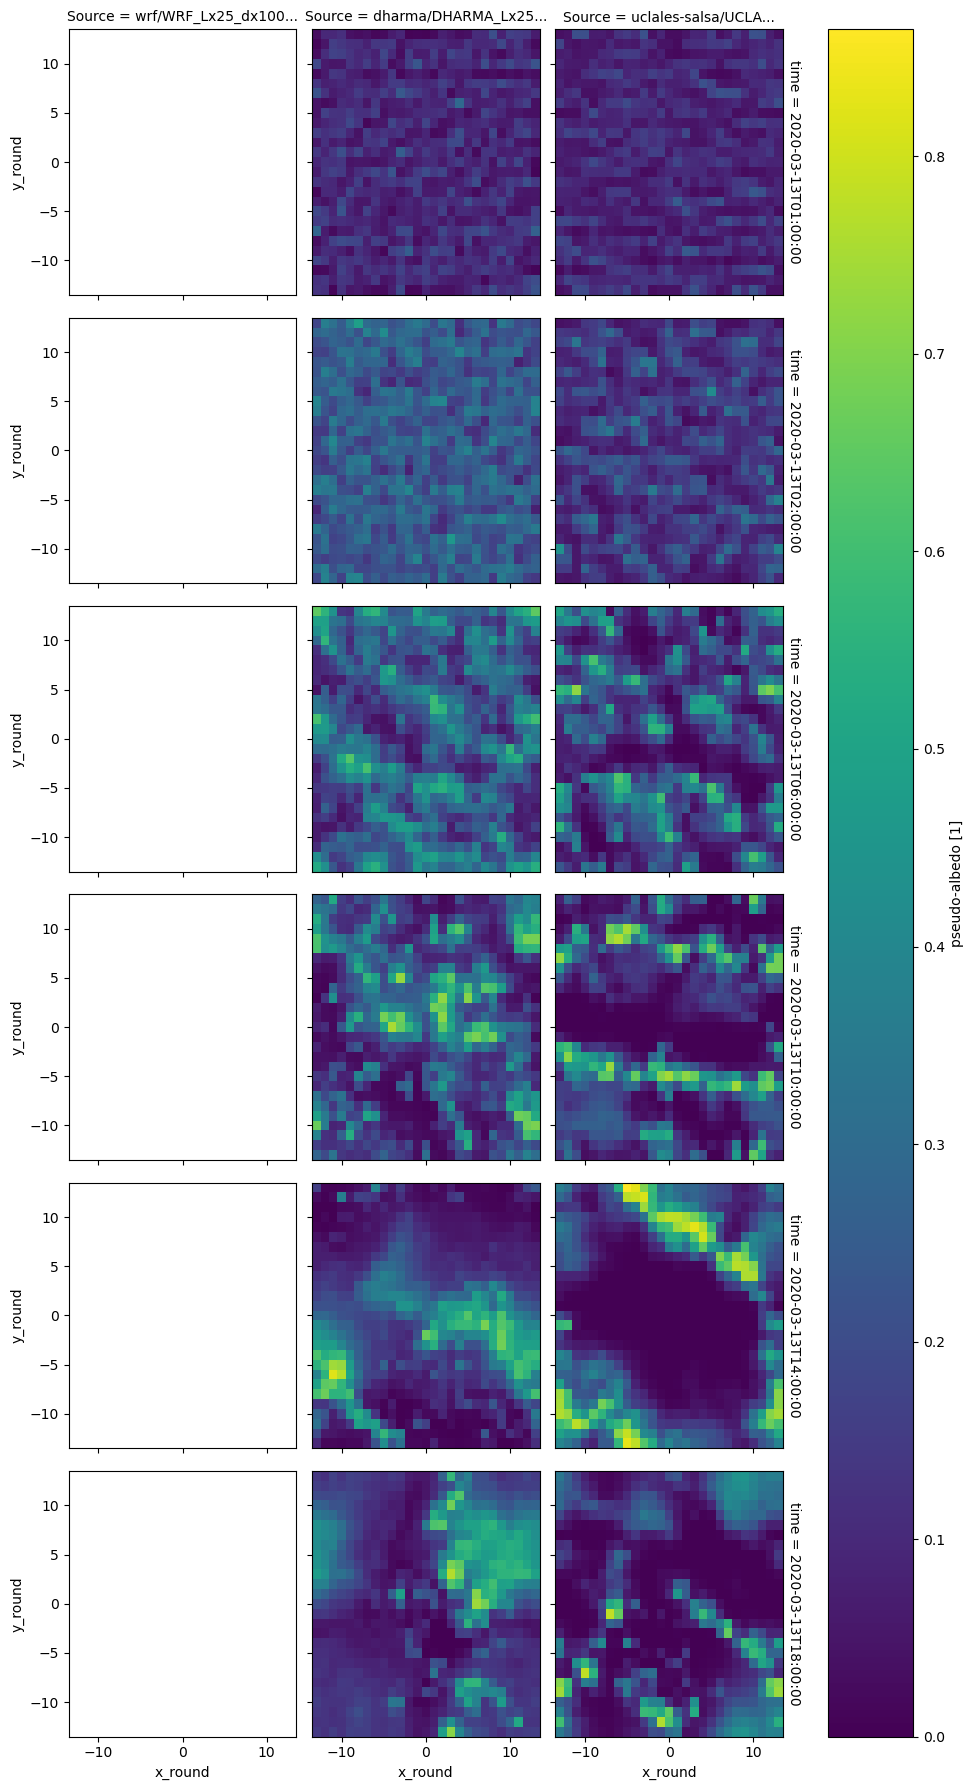

In [128]:
df_col_2d['alb'].plot(row='time',col_wrap=7,col='Source')

/tmp/ipykernel_173/3852338689.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  xr.merge([df_col_2d['alb'],da_stat_ststst.drop('time_diff')])['alb'].plot(row='time',col='Source')


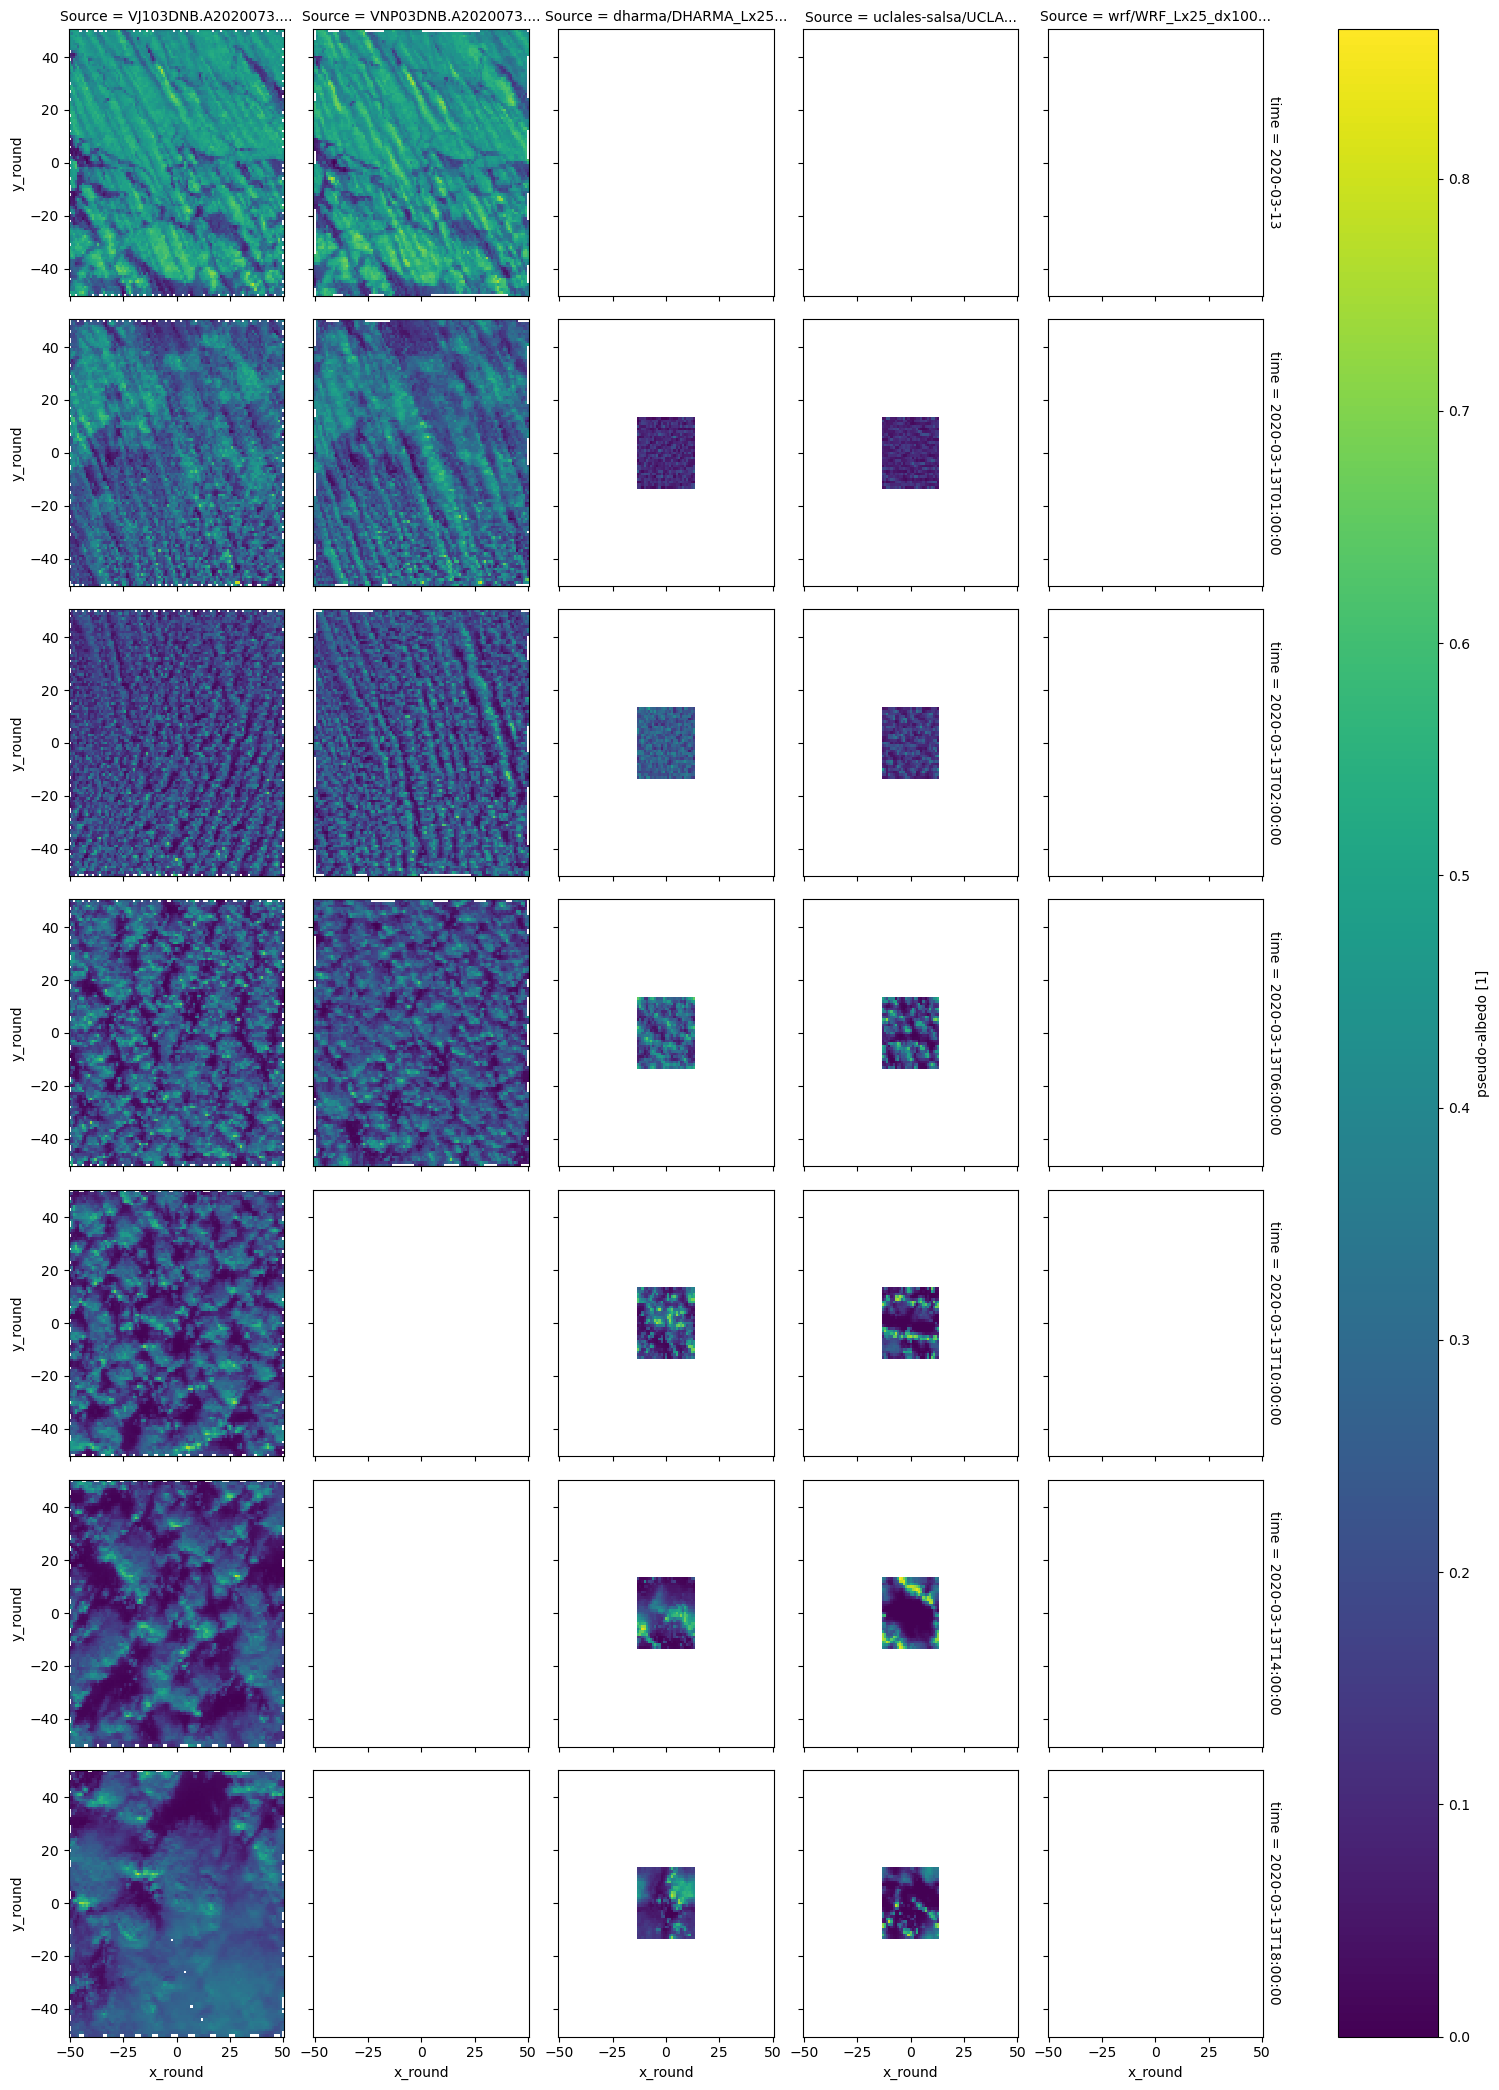

In [15]:
xr.merge([df_col_2d['alb'],da_stat_ststst.drop('time_diff')])['alb'].plot(row='time',col='Source')

In [132]:
df_col_2d.isel(Source=1)['Source'].data

array('dharma/DHARMA_Lx25_dx100_FixN_2D.nc', dtype='<U49')

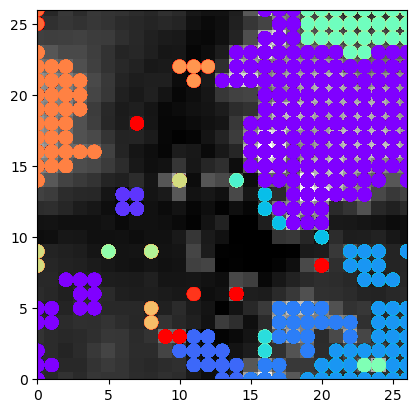

8_8
1_1
2_2
3_3
4_4
5_5
6_6
7_7
8_8
                slope   intercept      area                time  \
cluster                                                           
1       -1.216006e-01  213.132625  0.190672 2020-03-13 18:00:00   
2       -8.306709e-02  190.784345  0.042524 2020-03-13 18:00:00   
3        4.962095e-01  -58.787388  0.027435 2020-03-13 18:00:00   
4       -4.085708e-17   14.500000  0.002743 2020-03-13 18:00:00   
5        9.654905e-17   34.500000  0.002743 2020-03-13 18:00:00   

                                      Source  
cluster                                       
1        dharma/DHARMA_Lx25_dx100_FixN_2D.nc  
2        dharma/DHARMA_Lx25_dx100_FixN_2D.nc  
3        dharma/DHARMA_Lx25_dx100_FixN_2D.nc  
4        dharma/DHARMA_Lx25_dx100_FixN_2D.nc  
5        dharma/DHARMA_Lx25_dx100_FixN_2D.nc  


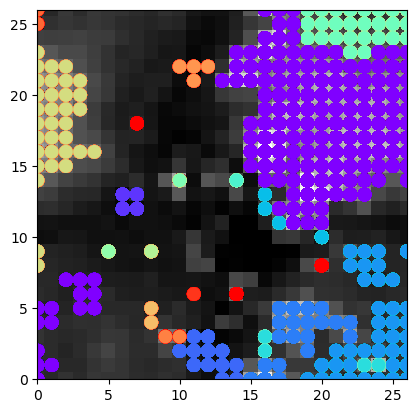

In [143]:
import os, sys, tarfile
from pathlib import Path
import netCDF4 as nc
from numpy import *
import matplotlib.pyplot as plt
import glob
import pandas as pd
## test to apply clustering algorithm ###

## certain properties
RES_ORG = 0.1
RES_CLA = 1.0

## certain thresholds
counter = 0
for ss in [2,1]:
    print(ss)
    for tt in [5]:
        pseudo_alb = df_col_2d['alb'].isel(time=tt).isel(Source=ss).data
        opd_cloud  = df_col_2d['opt'].isel(time=tt).isel(Source=ss).data

        THRES_CONNECT = quantile(pseudo_alb[(opd_cloud) > 2.0],0.50)
        THRES_CLOUD   = quantile(pseudo_alb[(opd_cloud) > 2.0],0.50)
    
        if sum(pseudo_alb > THRES_CLOUD) > 1:
            CLUST_COORDS = id_watershed(pseudo_alb,THRES_CLOUD,THRES_CONNECT,plotting=True)
            CLUST_GEOM = cluster_geometry(CLUST_COORDS_BIG,total=[(shape(pseudo_alb)[0]*shape(pseudo_alb)[1])])
            CLUST_GEOM['time']   = df_col_2d.isel(time=tt).isel(Source=ss)['time'].data
            CLUST_GEOM['Source'] = df_col_2d.isel(time=tt).isel(Source=ss)['Source'].data
            print(CLUST_GEOM)
            if counter == 0:
                CLUST_GEOM_COL = pd.concat([CLUST_GEOM])
            else:
                CLUST_GEOM_COL = pd.concat([CLUST_GEOM_COL,CLUST_GEOM])
            counter +=1
    
## coarsen field
#var_coarse = coarsen_2d(pseudo_alb,RES_CLA=RES_CLA,RES_ORG=RES_ORG)
#nx_coa = var_coarse.shape[0]


#plt.imshow(df_col_2d['alb'].isel(time=3).isel(Source=1).data)

In [142]:
CLUST_GEOM_COL

,slope,intercept,area,time,Source
cluster,,,,,
1,-1.216006e-01,213.132625,0.190672,2020-03-13 18:00:00,uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
2,-8.306709e-02,190.784345,0.042524,2020-03-13 18:00:00,uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
3,4.962095e-01,-58.787388,0.027435,2020-03-13 18:00:00,uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
4,-4.085708e-17,14.500000,0.002743,2020-03-13 18:00:00,uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
5,9.654905e-17,34.500000,0.002743,2020-03-13 18:00:00,uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
1,-1.216006e-01,213.132625,0.190672,2020-03-13 18:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc
2,-8.306709e-02,190.784345,0.042524,2020-03-13 18:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc
3,4.962095e-01,-58.787388,0.027435,2020-03-13 18:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc
4,-4.085708e-17,14.500000,0.002743,2020-03-13 18:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc


In [137]:

CLUST_COORDS_BIG = CLUST_COORDS.copy()


CLUST_COORDS_BIG['x'] = (CLUST_COORDS['x']*RES_CLA/RES_ORG) + (RES_CLA/RES_ORG - 1)/2
CLUST_COORDS_BIG['y'] = (CLUST_COORDS['y']*RES_CLA/RES_ORG) + (RES_CLA/RES_ORG - 1)/2

    
CLUST_GEOM = cluster_geometry(CLUST_COORDS_BIG,total=[(shape(pseudo_alb)[0]*shape(pseudo_alb)[1])])
CLUST_GEOM['time'] = 1
pd.concat([CLUST_GEOM,CLUST_GEOM])

,slope,intercept,area,time
cluster,,,,
1,-1.216006e-01,213.132625,0.190672,1
2,-8.306709e-02,190.784345,0.042524,1
3,4.962095e-01,-58.787388,0.027435,1
4,-4.085708e-17,14.500000,0.002743,1
5,9.654905e-17,34.500000,0.002743,1
1,-1.216006e-01,213.132625,0.190672,1
2,-8.306709e-02,190.784345,0.042524,1
3,4.962095e-01,-58.787388,0.027435,1
4,-4.085708e-17,14.500000,0.002743,1


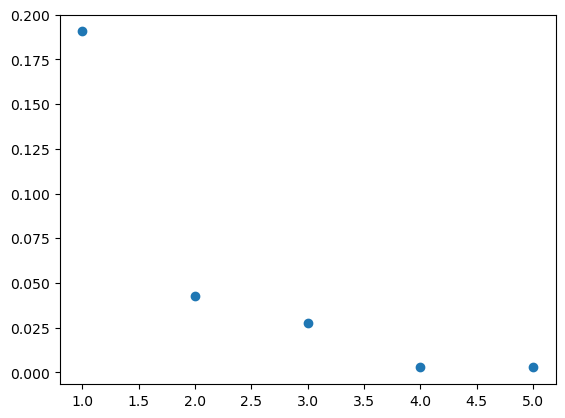

In [138]:
plt.scatter(CLUST_GEOM.index,CLUST_GEOM.area)

Loading variables: f(time,x,y)
/data/project/comble-mip/output_les/dharma/DHARMA_Lx25_dx100_FixN_2D.nc


/opt/conda/lib/python3.10/site-packages/xarray/plot/facetgrid.py:187: UserWarning: Ignoring col_wrap since both col and row were passed
  warnings.warn("Ignoring col_wrap since both col and row were passed")


<Figure size 640x480 with 0 Axes>

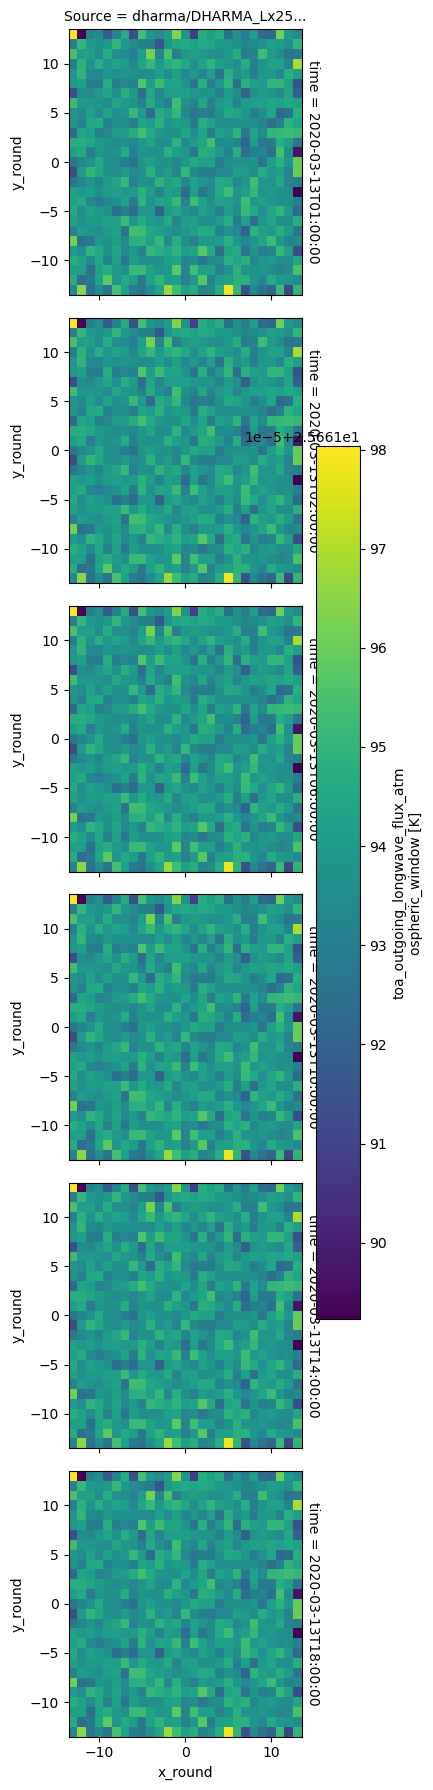

In [120]:

## select simulations to plot
sim_keyword = 'DHARMA_Lx25_dx100_FixN_2D' #UCLALES-SALSA_Lx25_dx100_FixN_2D'  

os.chdir("/user-data-home/comble-mip/notebooks/plotting/")
%run functions_plotting.py 

## load all simulations located in subfolders of the given directory
df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec if t > 0],coarsen=True)
var_vec_2d = ['olr11']

df_col_2d['olr11'].plot(row='time',col_wrap=7,col='Source')

In [13]:
df_col_2d['olr11'].isel(time=0)

<xarray.DataArray 'olr11' (y_round: 27, x_round: 27, Source: 1)> Size: 6kB
array([[[253.00684018],
        [200.21166835],
        [206.45327519],
        [153.97733599],
        [171.14216755],
        [195.42908044],
        [149.08899954],
        [160.87667474],
        [218.32370182],
        [154.16340798],
        [209.84226114],
        [197.32282561],
        [238.65942104],
        [190.59523385],
        [180.03509762],
        [220.60162296],
        [161.73777538],
        [145.71087655],
        [211.15829711],
        [180.70734946],
...
        [176.44625696],
        [122.48134703],
        [165.932213  ],
        [186.16640133],
        [199.90881729],
        [163.75942924],
        [205.4833733 ],
        [194.84073024],
        [176.71741949],
        [156.71006944],
        [236.82649673],
        [202.74368832],
        [228.14344887],
        [189.11293434],
        [180.53850425],
        [183.38523854],
        [180.08531414],
        [198.1234666 ],
        [154.10369175],
        [180.1776824 ]]])
Coordinates:
  * x_round  (x_round) float64 216B -13.0 -12.0 -11.0 -10.0 ... 11.0 12.0 13.0
    time     datetime64[ns] 8B 2020-03-13T01:00:00
  * Source   (Source) <U49 196B 'uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_...
  * y_round  (y_round) float64 216B -13.0 -12.0 -11.0 -10.0 ... 11.0 12.0 13.0
Attributes:
    units:      K
    long_name:  toa_outgoing_longwave_flux_atmospheric_window
    note:       Total LW